<a href="https://colab.research.google.com/github/ancientpi3/Chess-Python/blob/main/olivetti_DCGAN_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2
import numpy as np
from google.colab import drive
from google.colab import files
from zipfile import ZipFile
import cv2
import os

In [2]:
drive.mount('/content/gdrive')
filename = "/content/gdrive/MyDrive/olivetti_faces.npy.zip"

with ZipFile(filename, "r",) as zip:
  zip.extractall(path="/content/face_data")

Mounted at /content/gdrive


In [3]:
x_train_n = np.load("/content/face_data/olivetti_faces.npy")

In [4]:
x_train_n.shape

(400, 64, 64)

In [5]:
x_train = x_train_n*2 - 1

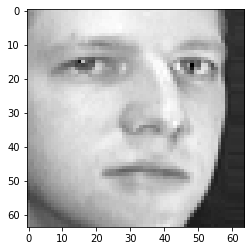

In [6]:
plt.imshow(x_train[4].reshape(64,64), cmap="gray")

In [7]:
latent_dim = 400

In [8]:
def discriminator():
  discriminator_input = keras.Input(shape=(64,64,1),name="d_input")
  
  x = keras.layers.Conv2D(256,(3,3),strides = (2,2),padding = "same", activation="leaky_relu")(discriminator_input)
  x = keras.layers.BatchNormalization(momentum=.9)(x,training=False)
  
  x = keras.layers.Conv2D(256,(3,3),strides = (2,2),padding = "same", activation="leaky_relu")(x)
  x = keras.layers.BatchNormalization(momentum=.9)(x,training=False)
  
  x = keras.layers.Conv2D(256,(3,3),strides = (2,2),padding = "same", activation="leaky_relu")(x)
  x = keras.layers.BatchNormalization(momentum=.9)(x,training=False)
  x = keras.layers.Dropout(rate=.3)(x)

  x = keras.layers.Conv2D(256,(3,3),strides = (2,2),padding = "same", activation="leaky_relu")(x)
  x = keras.layers.BatchNormalization(momentum=.9)(x,training=False)
  x = keras.layers.Dropout(rate=.3)(x)
  x = keras.layers.Flatten()(x)
  
  discriminator_output = keras.layers.Dense(1, activation='sigmoid')(x)
  model = keras.Model(discriminator_input, discriminator_output,name="discriminator")
  opt = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [9]:
def generator(latent_dim=latent_dim):
  generator_input = keras.Input(shape=(latent_dim),name="g_input")
  n_nodes = 8*8*256

  x = keras.layers.Dense(n_nodes)(generator_input)
  x = keras.layers.BatchNormalization(momentum=.9)(x,training=True)
  x = keras.layers.Dropout(rate=.3)(x)

  x = keras.layers.Reshape((8,8,256))(x)
  x = keras.layers.Conv2DTranspose(256,(3,3),strides=(2,2),padding='same',activation="relu")(x)
  x = keras.layers.BatchNormalization(momentum=.9)(x,training=True)
  x = keras.layers.Dropout(rate=.3)(x)
  
  x = keras.layers.Conv2DTranspose(256,(3,3),strides=(2,2),padding='same',activation="relu")(x)
  x = keras.layers.BatchNormalization(momentum=.9)(x,training=True)
  x = keras.layers.Dropout(rate=.3)(x)
  
  x = keras.layers.Conv2DTranspose(256,(3,3),strides=(2,2),padding='same',activation="relu")(x)
  x = keras.layers.BatchNormalization(momentum=.9)(x,training=True)
  x = keras.layers.Dropout(rate=.3)(x)
  
  generator_output = keras.layers.Conv2D(1,(7,7),padding="same",activation="tanh")(x)
  return keras.Model(generator_input, generator_output,name="generator")

In [10]:
d_model = discriminator()
d_model.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 d_input (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 256)       2560      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 256)      1024      
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 256)       590080    
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 256)      1024      
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)       

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [11]:
g_model = generator()
g_model.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 g_input (InputLayer)        [(None, 400)]             0         
                                                                 
 dense_1 (Dense)             (None, 16384)             6569984   
                                                                 
 batch_normalization_4 (Batc  (None, 16384)            65536     
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 256)      590080    
 nspose)                                                 

In [12]:
def GAN(d_model,g_model):
	d_model.trainable = False
	model = keras.models.Sequential()
	model.add(g_model)
	model.add(d_model)
	opt = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [13]:
GAN_model = GAN(d_model,g_model)
GAN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator (Functional)      (None, 64, 64, 1)         8421377   
                                                                 
 discriminator (Functional)  (None, 1)                 1780993   
                                                                 
Total params: 10,202,370
Trainable params: 8,387,073
Non-trainable params: 1,815,297
_________________________________________________________________


In [14]:
def grab_real_batch(x_train, batch_size):
	ix = np.random.randint(0, x_train.shape[0], batch_size)
	X = x_train[ix]
	#y = np.ones((batch_size, 1))
	return X

In [15]:
def grab_fake_batch(g_model,batch_size, latent_dim=latent_dim):
  latent_points = np.random.randn(latent_dim*batch_size).reshape(batch_size,latent_dim)
  predictions = g_model.predict(latent_points,verbose=0)
  return predictions

In [16]:
def save_plot(examples, epoch, n=5):
	for i in range(25):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, 0], cmap='gray')
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	plt.show()
	#plt.savefig(filename)
	plt.close()

In [25]:
def train(d_model,g_model,gan_model, x_train, epochs=400, verbose=1, print_every=20):
  latent_dim = g_model.input.shape[1]
  batch_size = 24
  half_batch = int(batch_size/2)
  batches_per_epoch = 64
  save_plot(grab_fake_batch(g_model,50).reshape(50,64,64,1),epoch=0)
  d_real_history = []
  d_fake_history = []
  gan_history = []
  for epoch in range(epochs):
    print("Epoch: ",epoch)
    for _ in range(batches_per_epoch):
      d_model.trainable = True

      #print("training discriminator on real batch")
      real_batch = grab_real_batch(x_train, half_batch)
      d_model.train_on_batch(x=real_batch.reshape(half_batch,64,64,1), y = np.ones(half_batch))
      #print("training discriminator on fake batch")
      fake_batch = grab_fake_batch(g_model, half_batch)
      d_model.train_on_batch(x=fake_batch.reshape(half_batch,64,64,1), y = np.zeros(half_batch))

      d_model.trainable = False
      #print("training GAN on fake batch with real label to measure how well G fools D")
      latent_points = np.random.randn(latent_dim*batch_size).reshape(batch_size,latent_dim)
      gan_model.train_on_batch(x=latent_points, y=np.ones(batch_size))

    #record batch history
    real_batch = grab_real_batch(x_train, batch_size)
    d_real_history.append(d_model.test_on_batch(x=real_batch.reshape(batch_size,64,64,1), y = np.ones(batch_size)))

    fake_batch = grab_fake_batch(g_model, batch_size)
    d_fake_history.append(d_model.test_on_batch(x=fake_batch.reshape(batch_size,64,64,1), y = np.zeros(batch_size)))

    latent_points = np.random.randn(latent_dim*batch_size).reshape(batch_size,latent_dim)
    gan_history.append(gan_model.test_on_batch(x=latent_points, y=np.ones(batch_size)))

    if(epoch%print_every==print_every-1):
      save_plot(grab_fake_batch(g_model,50).reshape(50,64,64,1),epoch=epoch)
  return np.array(d_real_history),np.array(d_fake_history),np.array(gan_history)

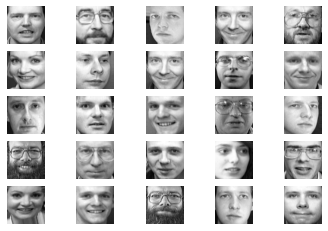

In [18]:
save_plot(grab_real_batch(x_train,40).reshape(40,64,64,1),epoch=-1)

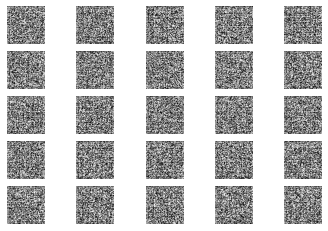

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9


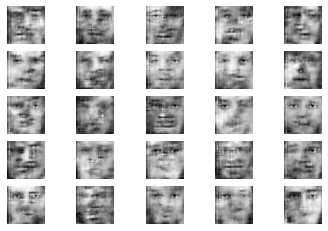

Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19


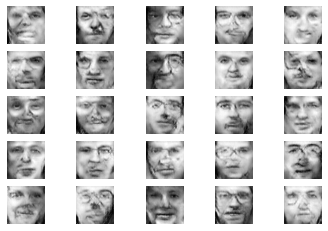

Epoch:  20
Epoch:  21
Epoch:  22
Epoch:  23
Epoch:  24
Epoch:  25
Epoch:  26
Epoch:  27
Epoch:  28
Epoch:  29


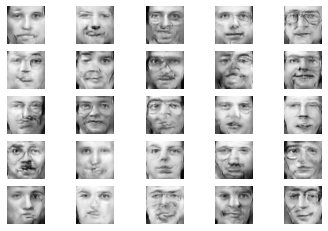

Epoch:  30
Epoch:  31
Epoch:  32
Epoch:  33
Epoch:  34
Epoch:  35
Epoch:  36
Epoch:  37
Epoch:  38
Epoch:  39


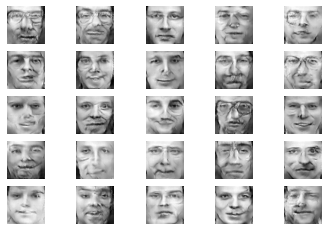

Epoch:  40
Epoch:  41
Epoch:  42
Epoch:  43
Epoch:  44
Epoch:  45
Epoch:  46
Epoch:  47
Epoch:  48
Epoch:  49


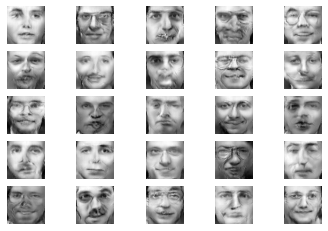

Epoch:  50
Epoch:  51
Epoch:  52
Epoch:  53
Epoch:  54
Epoch:  55
Epoch:  56
Epoch:  57
Epoch:  58
Epoch:  59


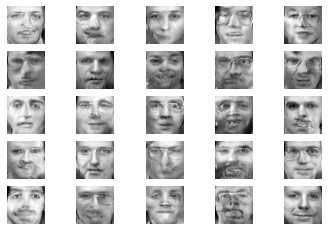

Epoch:  60
Epoch:  61
Epoch:  62
Epoch:  63
Epoch:  64
Epoch:  65
Epoch:  66
Epoch:  67
Epoch:  68
Epoch:  69


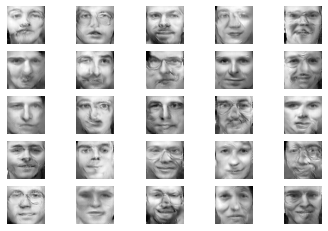

Epoch:  70
Epoch:  71
Epoch:  72
Epoch:  73
Epoch:  74
Epoch:  75
Epoch:  76
Epoch:  77
Epoch:  78
Epoch:  79


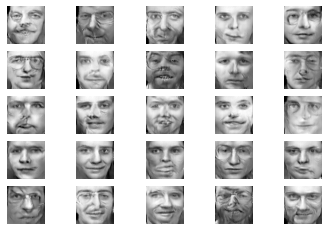

Epoch:  80
Epoch:  81
Epoch:  82
Epoch:  83
Epoch:  84
Epoch:  85
Epoch:  86
Epoch:  87
Epoch:  88
Epoch:  89


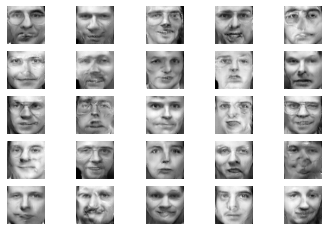

Epoch:  90
Epoch:  91
Epoch:  92
Epoch:  93
Epoch:  94
Epoch:  95
Epoch:  96
Epoch:  97
Epoch:  98
Epoch:  99


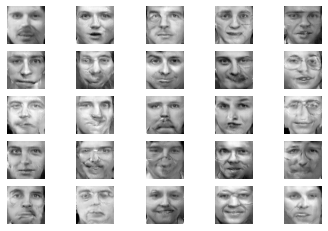

Epoch:  100
Epoch:  101
Epoch:  102
Epoch:  103
Epoch:  104
Epoch:  105
Epoch:  106
Epoch:  107
Epoch:  108
Epoch:  109


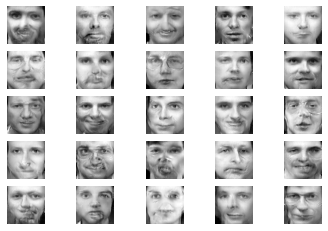

Epoch:  110
Epoch:  111
Epoch:  112
Epoch:  113
Epoch:  114
Epoch:  115
Epoch:  116
Epoch:  117
Epoch:  118
Epoch:  119


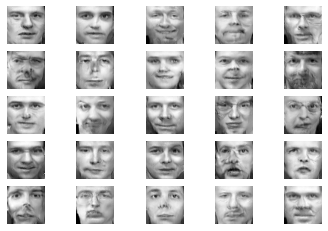

Epoch:  120
Epoch:  121
Epoch:  122
Epoch:  123
Epoch:  124
Epoch:  125
Epoch:  126
Epoch:  127
Epoch:  128
Epoch:  129


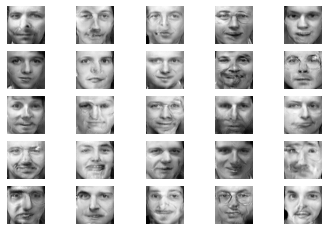

Epoch:  130
Epoch:  131
Epoch:  132
Epoch:  133
Epoch:  134
Epoch:  135
Epoch:  136
Epoch:  137
Epoch:  138
Epoch:  139


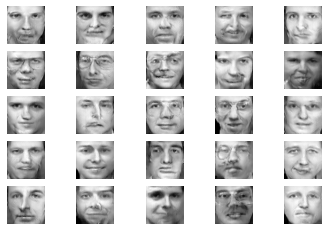

Epoch:  140
Epoch:  141
Epoch:  142
Epoch:  143
Epoch:  144
Epoch:  145
Epoch:  146
Epoch:  147
Epoch:  148
Epoch:  149


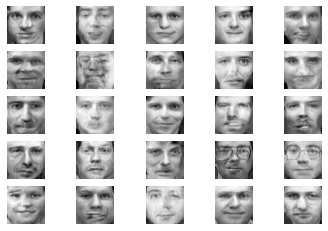

Epoch:  150
Epoch:  151
Epoch:  152
Epoch:  153
Epoch:  154
Epoch:  155
Epoch:  156
Epoch:  157
Epoch:  158
Epoch:  159


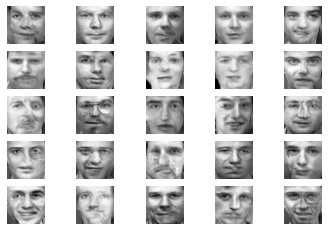

Epoch:  160
Epoch:  161
Epoch:  162
Epoch:  163
Epoch:  164
Epoch:  165
Epoch:  166
Epoch:  167
Epoch:  168
Epoch:  169


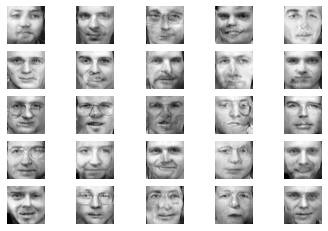

Epoch:  170
Epoch:  171
Epoch:  172
Epoch:  173
Epoch:  174
Epoch:  175
Epoch:  176
Epoch:  177
Epoch:  178
Epoch:  179


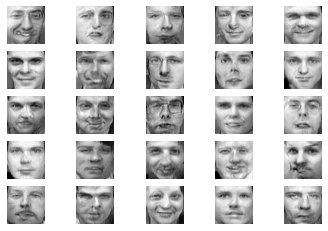

Epoch:  180
Epoch:  181
Epoch:  182
Epoch:  183
Epoch:  184
Epoch:  185
Epoch:  186
Epoch:  187
Epoch:  188
Epoch:  189


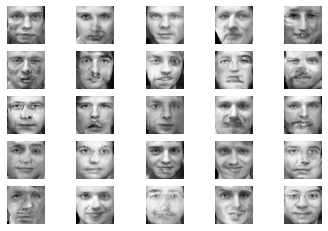

Epoch:  190
Epoch:  191
Epoch:  192
Epoch:  193
Epoch:  194
Epoch:  195
Epoch:  196
Epoch:  197
Epoch:  198
Epoch:  199


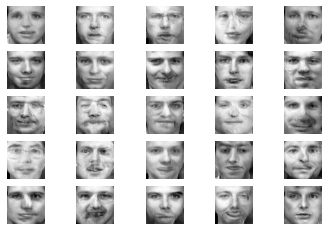

Epoch:  200
Epoch:  201
Epoch:  202
Epoch:  203
Epoch:  204
Epoch:  205
Epoch:  206
Epoch:  207
Epoch:  208
Epoch:  209


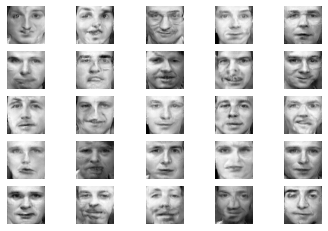

Epoch:  210
Epoch:  211
Epoch:  212
Epoch:  213
Epoch:  214
Epoch:  215
Epoch:  216
Epoch:  217
Epoch:  218
Epoch:  219


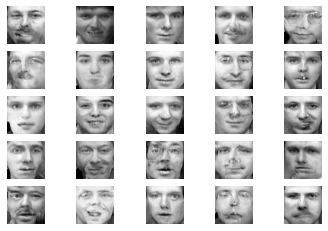

Epoch:  220
Epoch:  221
Epoch:  222
Epoch:  223
Epoch:  224
Epoch:  225
Epoch:  226
Epoch:  227
Epoch:  228
Epoch:  229


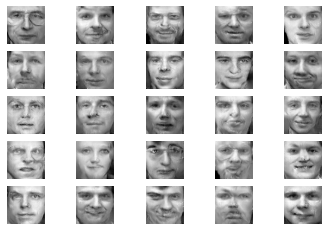

Epoch:  230
Epoch:  231
Epoch:  232
Epoch:  233
Epoch:  234
Epoch:  235
Epoch:  236
Epoch:  237
Epoch:  238
Epoch:  239


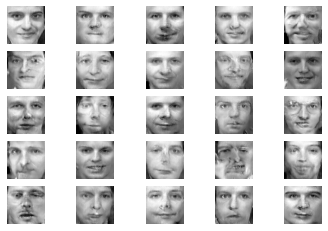

Epoch:  240
Epoch:  241
Epoch:  242
Epoch:  243
Epoch:  244
Epoch:  245
Epoch:  246
Epoch:  247
Epoch:  248
Epoch:  249


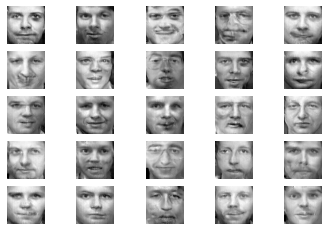

Epoch:  250
Epoch:  251
Epoch:  252
Epoch:  253
Epoch:  254
Epoch:  255
Epoch:  256
Epoch:  257
Epoch:  258
Epoch:  259


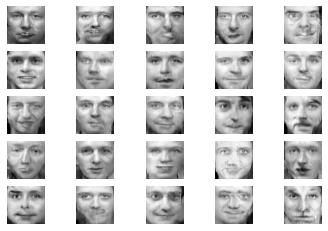

Epoch:  260
Epoch:  261
Epoch:  262
Epoch:  263
Epoch:  264
Epoch:  265
Epoch:  266
Epoch:  267
Epoch:  268
Epoch:  269


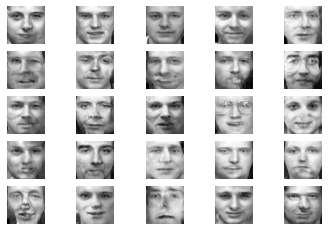

Epoch:  270
Epoch:  271
Epoch:  272
Epoch:  273
Epoch:  274
Epoch:  275
Epoch:  276
Epoch:  277
Epoch:  278
Epoch:  279


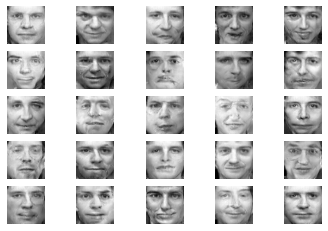

Epoch:  280
Epoch:  281
Epoch:  282
Epoch:  283
Epoch:  284
Epoch:  285
Epoch:  286
Epoch:  287
Epoch:  288
Epoch:  289


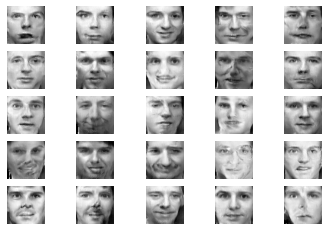

Epoch:  290
Epoch:  291
Epoch:  292
Epoch:  293
Epoch:  294
Epoch:  295
Epoch:  296
Epoch:  297
Epoch:  298
Epoch:  299


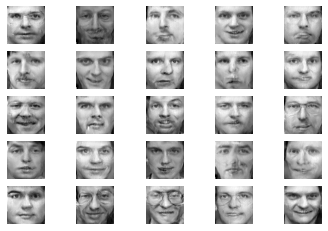

In [26]:
histories = train(d_model,g_model, GAN_model,x_train, verbose=0, print_every=10, epochs=300)

In [27]:
def display_histories(histories):
  d_real_history,d_fake_history,gan_history = histories
  d_real_acc = []
  d_real_loss = []
  for h in d_real_history:
    d_real_loss.append(h[0])
    d_real_acc.append(h[1])
  d_real_loss = np.array(d_real_loss)
  d_real_acc = np.array(d_real_acc)

  d_fake_acc = []
  d_fake_loss = []
  for h in d_fake_history:
    d_fake_loss.append(h[0])
    d_fake_acc.append(h[1])
  d_fake_loss = np.array(d_fake_loss)
  d_fake_acc = np.array(d_fake_acc)


  plt.plot(d_real_acc, label = "discriminator - real accuracy")
  plt.plot(d_fake_acc, label = "discriminator - fake accuracy")

  plt.plot(d_real_loss, label = "discriminator - real loss")
  plt.plot(d_fake_loss, label = "discriminator - fake loss")

  #plt.plot(gan_history, label = "generator - loss")

  plt.xlabel("epochs")
  plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=2)

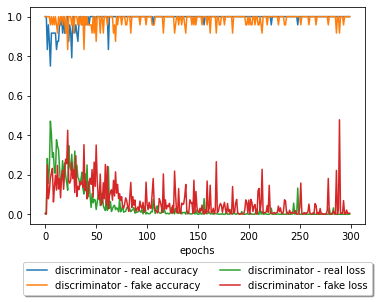

In [28]:
display_histories(histories)

In [29]:
g_model.save("olivetti_dcgan_g_model_v4.h5")